
# Time Series Forecasting with Auto-Arima

In [1]:
%matplotlib inline

# ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# data manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams
import scipy

# set font scale and style
plt.rcParams.update({'font.size': 18})

# stat models
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

# preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer

In [2]:
# import custom class
%run -i '../src/time_series.py'

In [3]:
# instantiate the class
ts_fcst = TimeSeriesForecasting()

# Load  data

In [4]:
ts = pd.read_csv('../data/ts_data.csv') # load data
ts.date = pd.to_datetime(ts['date'])  # convert to datetime
ts.index = ts.date # make date the dataframe index
ts = ts.drop(['date'], axis =1)
ts.dropna(inplace = True) # drop rows with missing values
print("Data size:", ts.shape)
ts.head()

Data size: (77, 3)


,sales,year,month
date,,,
2015-01-01,154.0,2015,1
2015-02-01,96.0,2015,2
2015-03-01,73.0,2015,3
2015-04-01,49.0,2015,4
2015-05-01,36.0,2015,5


In [5]:
ts['yr_mnth'] = ts.year + ts.month/12 # feature engineering

## Power Transformation needed?

To check if a power transformation (such as the Box-Cox transformation) of the target variable is necessary, we check if  $\text{max}(y_t)/\text{min}(y_t) >3$. If not, a power transformation might not provide much help.

In [6]:
np.max(ts['sales'])/np.min(ts['sales'])

24.86111111111111

##  Create a test  set
We must split the dataset into training (in-sample) and test (out-of-sample) set. 

In [7]:
y = ts['sales'] # actuals
N = len(y) # data size

cols_to_drop = ['sales', 'month', 'year']
exog_variables = list(ts.drop(cols_to_drop, axis=1).columns)
x_exog = ts[exog_variables]

# add seasonality variables
# x_exog['yearly_seasonality'] = np.arange(N) % 365
x_exog['monthly_seasonality'] = np.arange(N) % 30.5
# x_exog['weekly_seasonality'] = np.arange(N) % 7

In [8]:
train_start, train_end = '2015-01-01','2020-05-01'
test_start, test_end = '2020-05-01', '2021-05-01'

x_train = x_exog[train_start: train_end]
y_train = y[train_start: train_end]

x_test = x_exog[test_start: test_end]
y_test = y[test_start: test_end]

## Standardization

In [9]:
# standardization
pscaler = PowerTransformer(method='box-cox', standardize=True)
scaler = StandardScaler()

y_train_scaled = pscaler.fit_transform(y_train.values.reshape(-1,1)) 
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# pandas dataframe
x_train_df = pd.DataFrame(x_train_scaled, columns = x_train.columns)
x_test_df = pd.DataFrame(x_test_scaled, columns = x_test.columns)

## SARIMAX
We build Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors (SARIMAX) model using pmdarima‘s auto_arima(). We set seasonal = True, the frequency m = 12 for monthly time series, and seasonal differencing D = 1.

In [10]:
# train sarimax from auto-arima api
sarimax = pm.auto_arima(
    y_train_scaled, 
    exogenous=x_train_df, 
    max_p=2, max_q=2, 
    D=1, 
    m=12, 
    test='adf', 
    stepwise=True, 
    suppress_warnings=True, 
    error_action='ignore', 
    seasonal=True, 
    random_state=42, 
    trace=True, 
    n_fits=20,
    )
sarimax.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=2.76 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=33.964, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=17.667, Time=0.31 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=16.475, Time=0.27 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=19.054, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=1.12 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.79 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=19.032, Time=0.26 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.33 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=15.417, Time=0.54 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=18.841, Time=0.13 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.23 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=inf, Time=1.68 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=19.645, Time=0.38 sec
 AR

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   65
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                  -2.265
Date:                              Tue, 29 Nov 2022   AIC                             14.531
Time:                                      10:44:57   BIC                             24.287
Sample:                                           0   HQIC                            18.271
                                               - 65                                         
Covariance Type:                                opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
yr_mnth              8.133e-08   1.21e-09     67.155      0.000     7.9e-08    8.37e-08
monthly_seasonality     0.0140      0.050      0.278      0.781      -0.084       0.112
ar.L1                  -0.5217      0.141     -3.706      0.000      -0.798      -0.246
ma.S.L12               -0.6135      0.246     -2.494      0.013      -1.096      -0.131
sigma2                  0.0570      0.017      3.356      0.001       0.024       0.090
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.13
Prob(Q):                              0.90   Prob(JB):                         0.94
Heteroskedasticity (H):               1.29   Skew:                            -0.11
Prob(H) (two-sided):                  0.61   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.79e+24. Standard errors may be unstable.
"""

# Training set (in-sample) prediction

In [11]:
y_train_pred = pscaler.inverse_transform(
    y_train_scaled - sarimax.resid().values.reshape(-1,1)
    ).flatten()

In [12]:
print("Training set performance errors")
print(30*"-")
ts_fcst.error_metrics(y_train, y_train_pred)

Training set performance errors
------------------------------


{'MAPE': 17.614,
 'WMAPE': 13.51,
 'MASE': 0.542,
 'MAE': 35.58,
 'RMSE': 44.151,
 'R^2': 0.931}

## Model Diagnostics Plot on the Training Set

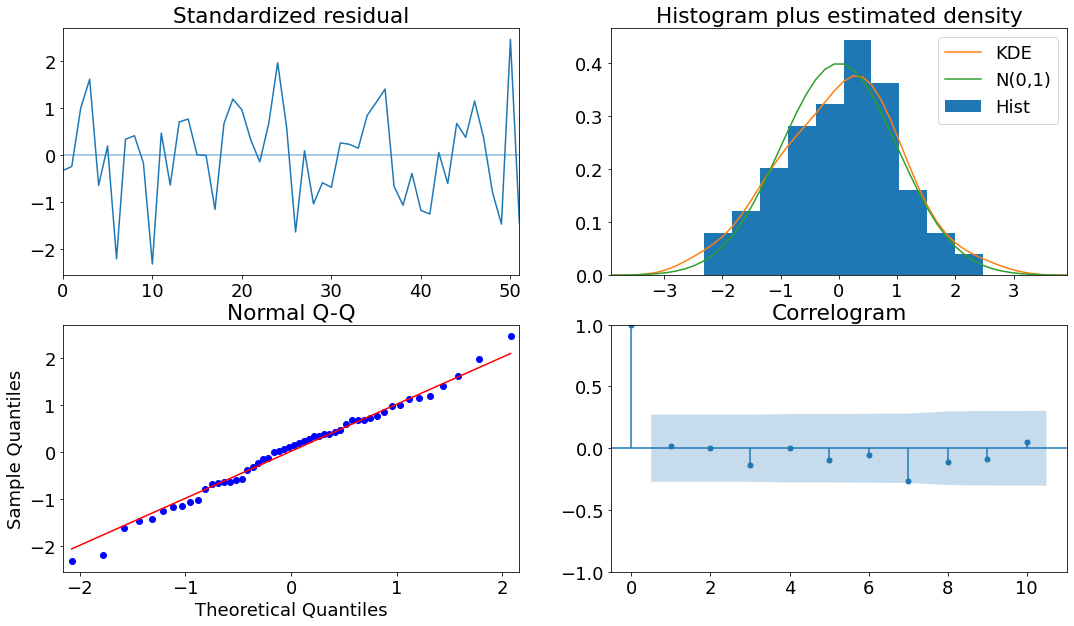

In [13]:
sarimax.plot_diagnostics(figsize=(18,10))
plt.show()

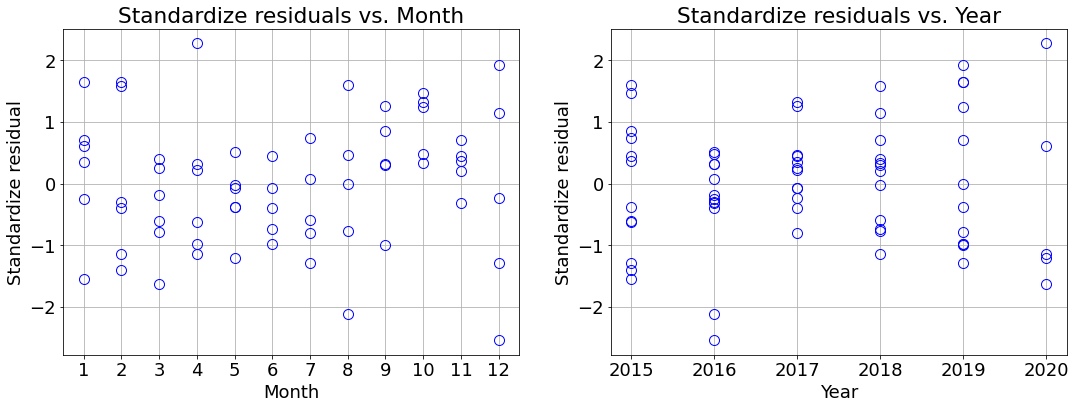

In [14]:
# training set standardize residual
tresid = y_train-y_train_pred
tstandard = (tresid-np.mean(tresid))/np.std(tresid)

plt.figure(figsize = (18,6))
plt.subplot(121)
plt.plot(
    tstandard.index.month, 
    tstandard, 
    color='b', 
    marker='o', 
    markerfacecolor='none',
    linestyle='', 
    markersize=10,
    )
plt.grid(True)
plt.xlabel('Month')
plt.ylabel('Standardize residual')
plt.xticks(np.arange(1,13,1))
plt.title('Standardize residuals vs. Month')

plt.subplot(122)
plt.plot(
    tstandard.index.year, 
    tstandard, 
    color='b', 
    marker='o', 
    markerfacecolor='none',
    linestyle='',
    markersize=10,
     )
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Standardize residual')
plt.xticks(np.arange(2015,2021))
plt.title('Standardize residuals vs. Year')
plt.show()

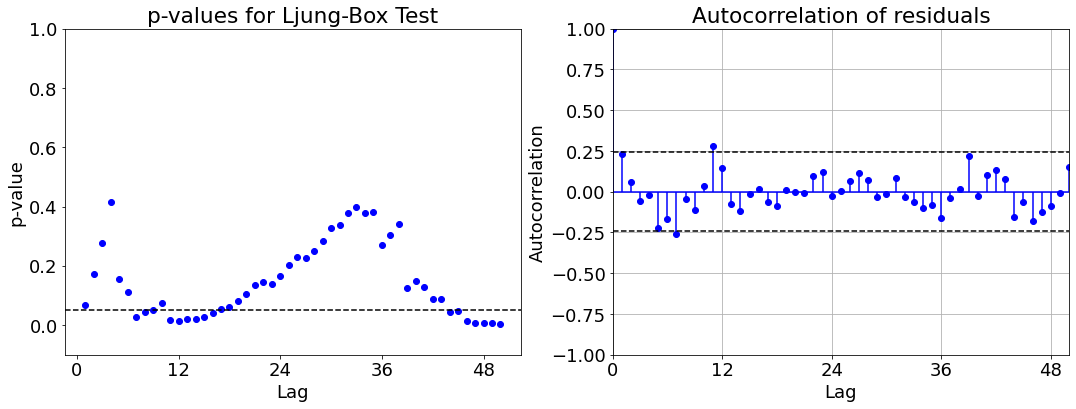

In [15]:
plt.figure(figsize = (18,6))
plt.subplot(121)
lb = acorr_ljungbox(tresid, lags = 50)[1]
plt.plot(np.arange(1,len(lb)+1), lb, 'o', color = 'b')
plt.axhline(y=0.05,linestyle= '--', color = 'k')
plt.ylabel('p-value')
plt.xlabel('Lag')
plt.xticks(np.arange(0,len(lb),12))
plt.ylim(-0.1,1)
plt.title('p-values for Ljung-Box Test')

plt.subplot(122)
plt.acorr(tresid, usevlines=True, maxlags=50, normed=True, color ='b')
plt.acorr(tresid, usevlines=False, maxlags=50, normed=True,color ='b')
plt.axhline(y=1.96/np.sqrt(len(tresid)),linestyle= '--', linewidth=1.5, color = 'k')
plt.axhline(y=-1.96/np.sqrt(len(tresid)),linestyle= '--', linewidth=1.5, color = 'k')
plt.xlim(0,50)
plt.ylim(-1,1)
plt.xticks(np.arange(0,50,12))
plt.grid(True)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of residuals')
plt.show()

# Test (out-of-sample) prediction

In [16]:
y_pred, conf_int = sarimax.predict(
    n_periods=len(y_test), 
    exogenous=x_test_df, 
    return_conf_int=True,
    )
y_pred = pscaler.inverse_transform(y_pred.reshape(-1,1)).flatten() # inverse transform scale

print("Test set performance errors")
print(30*"-")
ts_fcst.error_metrics(y_test, y_pred)

Test set performance errors
------------------------------


{'MAPE': 21.293,
 'WMAPE': 19.074,
 'MASE': 0.756,
 'MAE': 88.74,
 'RMSE': 111.886,
 'R^2': 0.775}

In [17]:
y_pred[y_pred<0] = 0

y_low = conf_int[:,0]
y_low = pscaler.inverse_transform(y_low.reshape(-1,1)).flatten()
y_high = conf_int[:,1]
y_high = pscaler.inverse_transform(y_high.reshape(-1,1)).flatten()

results = pd.DataFrame()
results['y_pred'] = y_pred
results['y_low'] = y_low
results['y_high'] = y_high
results.index = y_test.index

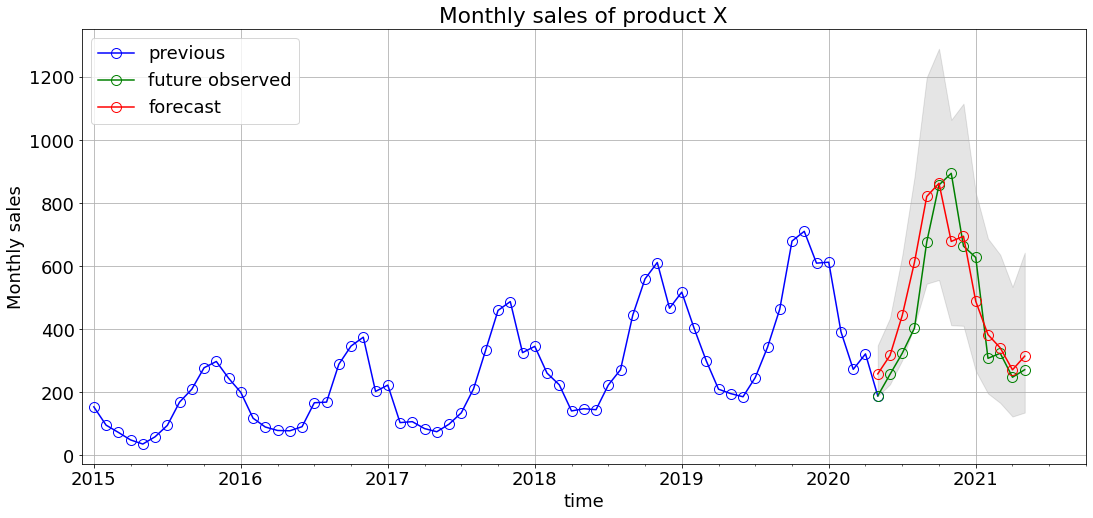

In [18]:
plt.figure(figsize = (18,8))

y_train.plot(
    label='previous',  
    marker='o', 
    color='b', 
    markersize=10, 
    markerfacecolor='none',
    )
y_test.plot(
    label='future observed', 
    marker='o', 
    color='g',
    markersize=10, 
    markerfacecolor='none',
    )
results['y_pred'].plot(
    label='forecast', 
    marker='o', 
    color='r', 
    markersize=10,
    markerfacecolor='none',
    )

plt.fill_between(
    results.index, 
    results['y_low'], 
    results['y_high'], 
    color='k', 
    alpha=0.1,
    )
plt.xlabel('time')
# plt.text('2010-02-01', 0.021, "WMAPE = 1.2%")
plt.grid(True)
plt.ylabel('Monthly sales')
plt.title('Monthly sales of product X')
plt.xlim('2014-12-01', '2021-10-01')
plt.legend(loc = 'upper left')
plt.savefig('../img/arima1.png')
plt.show()

## Model Diagnostics Plot on the Test Set

## 1. Standadized residual of the test set 

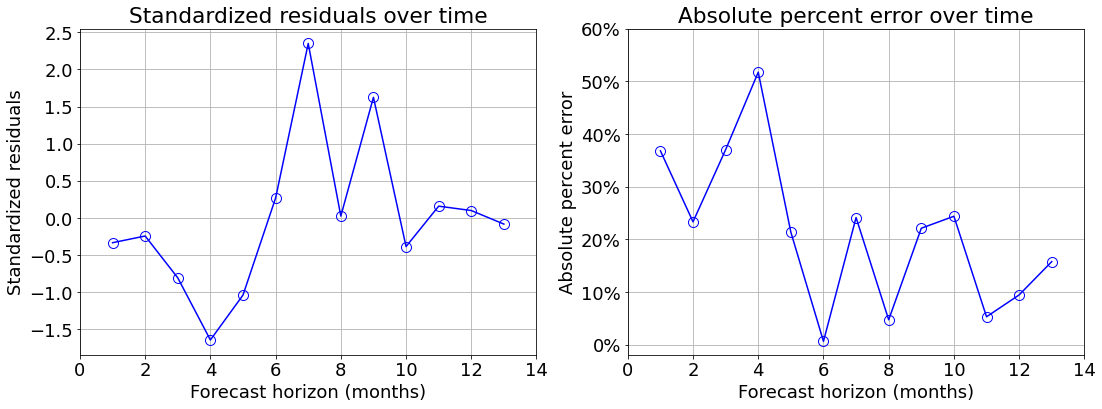

In [19]:
plt.figure(figsize = (18,6))
residual = y_test-results['y_pred']
rstandard = (residual-np.mean(residual))/np.std(residual)
ape = np.abs(residual)*100/np.abs(y_test)

plt.subplot(121)
plt.plot(
        range(1,len(rstandard)+1), 
        rstandard, 
        color='b', 
        marker='o', 
        markersize=10,
        markerfacecolor='none',
        )
plt.grid(True)
plt.xlabel('Forecast horizon (months)')
plt.ylabel('Standardized residuals')
plt.xlim(0,14)
plt.title('Standardized residuals over time')

plt.subplot(122)
plt.plot(
        range(1,len(ape)+1), 
        ape, 
        color='b',
        marker='o',
        markersize=10,
        markerfacecolor='none',
        )
plt.grid(True)
plt.xlabel('Forecast horizon (months)')
plt.ylabel('Absolute percent error')
plt.title('Absolute percent error over time')
label = [
        '0%', 
        '10%', 
        '20%', 
        '30%', 
        '40%', 
        '50%', 
        '60%',
        ]
plt.xlim(0,14)
plt.yticks(np.arange(0,65,10),label)
plt.savefig('../img/arima2.png')
plt.show()

## 2. Ljung-Box test

A good forecasting model will have zero correlation between its residuals. Correlation in residuals means that some information were left out which should have been used in forecasting.

We use the Ljung-Box test to check if the residuals (absolute percent error) from the time series model resemble white noise (i.e., zero autocorrelation). The null hypothesis states that the residuals are independently and identically distributed, that is the errors are uncorrelated. Therefore, a p-value greater than 0.05 means that we do not have enough information (or statistically significant evidence) to reject the null hypothesis. However, this does not mean that the forecasting model cannot be improved.

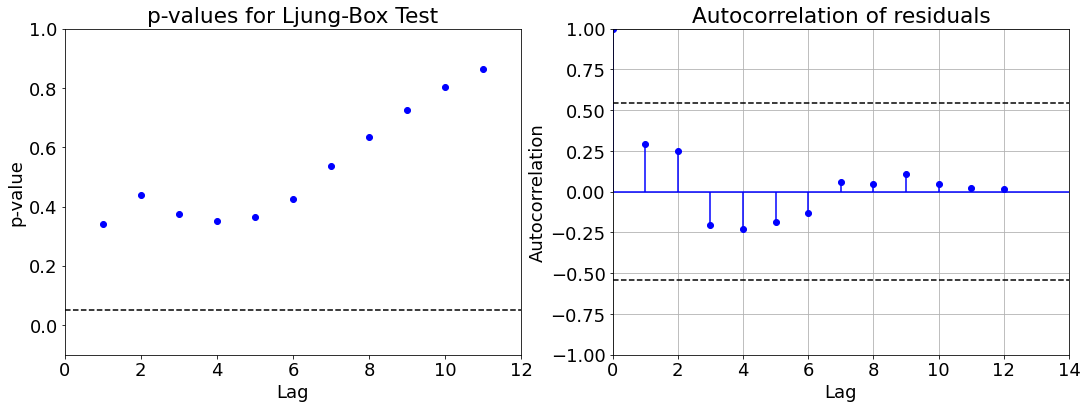

In [20]:
plt.figure(figsize = (18,6))
plt.subplot(121)
lb = acorr_ljungbox(residual, lags = 11)[1]
plt.plot(np.arange(1,len(lb)+1), lb, 'o', color = 'b')
plt.axhline(y=0.05,linestyle= '--', color = 'k')
plt.ylabel('p-value')
plt.xlabel('Lag')
plt.ylim(-0.1,1)
plt.xlim(0,12)
plt.title('p-values for Ljung-Box Test')

plt.subplot(122)
plt.acorr(residual, usevlines=True, maxlags=len(residual)-1, normed=True, color ='b')
plt.acorr(residual, usevlines=False, maxlags=len(residual)-1, normed=True,color ='b')
plt.axhline(y=1.96/np.sqrt(len(residual)),linestyle= '--', linewidth=1.5, color = 'k')
plt.axhline(y=-1.96/np.sqrt(len(residual)),linestyle= '--', linewidth=1.5, color = 'k')
plt.xlim(0,len(residual)+1)
plt.ylim(-1,1)
# plt.xticks(np.arange(0,len(residual)+1,12))
plt.grid(True)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of residuals')
plt.savefig('../img/arima3.png')
plt.show()

# Forecasting

## Future dates

In [21]:
from datetime import datetime, timedelta

trange = np.arange(datetime(2015,1,1), datetime(2022,5,1), timedelta(days=31))
df = pd.DataFrame(pd.to_datetime(trange),columns= ['date1'])
df['year'] = df['date1'].dt.year
df['month'] = df['date1'].dt.month
df['yr_mnth'] = df.year + df.month/12

df['date2'] = df['year'].astype(str) + '-' + df['month'].astype(str)
df.insert(0, 'date', df.date2.values)
df.drop(['date1', 'date2'], axis = 1, inplace = True)
df.date = pd.to_datetime(df['date']) 
df.index = df.date
df.drop(['date'], axis =1, inplace = True)

future_df = df.merge(ts['sales'], how = 'left', on = 'date')
future_df.tail()

,year,month,yr_mnth,sales
date,,,,
2021-12-01,2021,12,2022.000000,NaN
2022-01-01,2022,1,2022.083333,NaN
2022-02-01,2022,2,2022.166667,NaN
2022-03-01,2022,3,2022.250000,NaN
2022-04-01,2022,4,2022.333333,NaN


## Preprocessing & Transformations

In [22]:
# actual
y = future_df['sales'] 
N = len(y)

# exogeneous variables
cols_to_drop = ['sales', 'month', 'year']
exog_variables = list(future_df.drop(cols_to_drop, axis=1).columns)
x_exog = future_df[exog_variables]

# add seasonality variables
x_exog['monthly_seasonality'] = np.arange(N) % 30.5

In [23]:
# training and future data
train_start, train_end = '2015-01-01','2021-05-01'
future_start, future_end = '2021-05-01', '2022-04-01'

x_train = x_exog[train_start: train_end]
y_train = y[train_start: train_end]
x_future = x_exog[future_start: future_end]
y_future = y[future_start: future_end] # just for the future dates

In [24]:
# power transformation & standardization
pscaler = PowerTransformer(method='box-cox', standardize=True)
scaler = StandardScaler()

y_train_scaled = pscaler.fit_transform(y_train.values.reshape(-1,1)) 
x_train_scaled = scaler.fit_transform(x_train)
x_future_scaled = scaler.transform(x_future)

# pandas dataframe
x_train_df = pd.DataFrame(x_train_scaled, columns = x_train.columns)
x_future_df = pd.DataFrame(x_future_scaled, columns = x_future.columns)

## Model training

In [25]:
# train sarimax from auto arima API
sarimax = pm.auto_arima(
    y_train_scaled,
    exogenous=x_train_df, 
    max_p=2, 
    max_q=2, 
    D=1, 
    m=12, 
    test='adf', 
    stepwise=True, 
    suppress_warnings=True, 
    error_action='ignore', 
    seasonal=True, 
    random_state=42, 
    trace=True, 
    n_fits=20,
    )
sarimax.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=1.39 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=52.003, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=31.538, Time=0.50 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=35.112, Time=0.50 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=31.210, Time=0.23 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=29.984, Time=0.58 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.90 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=inf, Time=1.38 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=2.19 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=47.833, Time=0.34 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=31.850, Time=0.46 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=31.871, Time=1.16 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=33.784, Time=2.06 sec
 ARIMA(1,1,0)(0,1,1)[12] intercept   : AIC=31.978, Time=0.65 sec

Best model:  ARIMA(1,1,0)(0,1,1)[12]          
Total fit t

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   76
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                  -9.992
Date:                              Tue, 29 Nov 2022   AIC                             29.984
Time:                                      10:45:17   BIC                             40.699
Sample:                                           0   HQIC                            34.198
                                               - 76                                         
Covariance Type:                                opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
yr_mnth                -8.3351      9.737     -0.856      0.392     -27.418      10.748
monthly_seasonality     0.0003      0.039      0.008      0.994      -0.077       0.078
ar.L1                  -0.5449      0.123     -4.427      0.000      -0.786      -0.304
ma.S.L12               -0.3955      0.139     -2.851      0.004      -0.667      -0.124
sigma2                  0.0774      0.014      5.457      0.000       0.050       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.09
Prob(Q):                              0.92   Prob(JB):                         0.21
Heteroskedasticity (H):               2.45   Skew:                            -0.54
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Model prediction

In [26]:
yhat, conf_int = sarimax.predict(
    n_periods=len(y_future),
     exogenous=x_future_df, 
     return_conf_int=True,
     )
yhat = pscaler.inverse_transform(yhat.reshape(-1,1)).flatten() # inverse transform scale

In [27]:
yhat[yhat<0] = 0

y_low = conf_int[:,0]
y_low = pscaler.inverse_transform(y_low.reshape(-1,1)).flatten()
y_high = conf_int[:,1]
y_high = pscaler.inverse_transform(y_high.reshape(-1,1)).flatten()

results = pd.DataFrame()
results['yhat'] = yhat
results['y_low'] = y_low
results['y_high'] = y_high
results.index = y_future.index

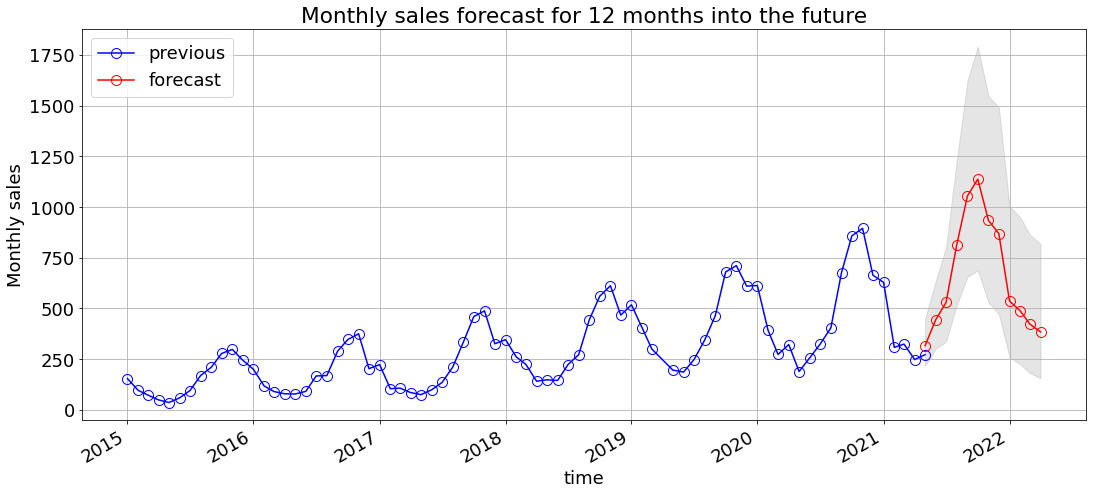

In [28]:
plt.figure(figsize = (18,8))

y_train.plot(
        label='previous',  
        marker='o', 
        color='b', 
        markersize=10,
        markerfacecolor='none',
        )
results['yhat'].plot(
        label='forecast', 
        marker='o', 
        color='r', 
        markersize=10,
        markerfacecolor='none',
        )
plt.fill_between(
        results.index, 
        results['y_low'], 
        results['y_high'], 
        color='k', 
        alpha=0.1,
        )
plt.xlabel('time')
plt.grid(True)
plt.ylabel('Monthly sales')
plt.title('Monthly sales forecast for 12 months into the future')
plt.legend(loc = 'upper left')
plt.savefig('../img/arima4.png')
plt.show()